In [172]:
# %pip install openpyxl matplotlib pandas micropip statsmodels scikit-learn

In [173]:
# 1) Installa engine Excel e Matplotlib
import micropip
await micropip.install(["openpyxl", "matplotlib"])

# 2) Librerie
import pandas as pd
import matplotlib.pyplot as plt

# Un'occhiata rapida al dataset

In [174]:
# 3) Leggi il foglio “CAUSALI A MANO” (header sulla seconda riga)
df = pd.read_excel(
    "ANALISI CAUSALI OEE.xlsx",
    sheet_name="CAUSALI A MANO",
    header=1
)

# 4) Vediamo l'head
print("Sheet caricato:", df.shape, "righe×colonne")
df.head()

Sheet caricato: (916, 11) righe×colonne


,Unnamed: 0,GG,SETT,GIORNO,POSTAZIONE,OPERATORE,CAUSALE,TEMPO ANNOTATO [min],DIFF,(FORSE) COMPRESO IN,CAUSALI POSTAZIONE
0,NaN,lun,6,2025-02-03,100,719,RIFORNIMENTO MORSETTIERA,15,NaN,NaN,NaN
1,NaN,lun,6,2025-02-03,100,714,PREPARAZIONE SCHEDE E CASSA NUOVA,15,NaN,5700,NaN
2,NaN,lun,6,2025-02-03,110,714,RIBATTUTO RACCORDO MINIFGX,10,NaN,NaN,NaN
3,NaN,lun,6,2025-02-03,110,714,RUBINETTO MANOMETRO DIFETTATO,10,NaN,NaN,NaN
4,NaN,lun,6,2025-02-03,110,59,NON ARRIVA CORRENTE,30,NaN,NaN,NaN


In [175]:
# 5) Informazioni generali
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            0 non-null      float64       
 1   GG                    916 non-null    object        
 2   SETT                  916 non-null    int64         
 3   GIORNO                916 non-null    datetime64[ns]
 4   POSTAZIONE            916 non-null    int64         
 5   OPERATORE             916 non-null    int64         
 6   CAUSALE               916 non-null    object        
 7   TEMPO ANNOTATO [min]  895 non-null    object        
 8   DIFF                  2 non-null      float64       
 9   (FORSE) COMPRESO IN   77 non-null     object        
 10  CAUSALI POSTAZIONE    4 non-null      object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 78.8+ KB


In [176]:
# 6) Statistiche descrittive su “TEMPO ANNOTATO [min]”
df['CAUSALE'].describe()

count                    916
unique                   197
top       RECUPERO MATERIALE
freq                     126
Name: CAUSALE, dtype: object

In [177]:
# --- CELL: pulizia colonne e conversione in numerico ---

# verifica prima come si chiamano esattamente le colonne
print(df.columns.tolist())

# rimuovo spazi bianchi per sicurezza
df.columns = df.columns.str.strip()

# converto in numerico (tutto ciò che non si riesce a convertire diventa NaN)
df['TEMPO ANNOTATO [min]'] = pd.to_numeric(df['TEMPO ANNOTATO [min]'], errors='coerce')

# se vuoi, sostituisci NaN con zero
df['TEMPO ANNOTATO [min]'] = df['TEMPO ANNOTATO [min]'].fillna(0).astype(int)

# controlla il tipo
print(df['TEMPO ANNOTATO [min]'].dtype)

['Unnamed: 0', 'GG', 'SETT', 'GIORNO', 'POSTAZIONE', 'OPERATORE', 'CAUSALE', 'TEMPO ANNOTATO [min]', 'DIFF', '(FORSE) COMPRESO IN', 'CAUSALI POSTAZIONE']
int64


# Pareto chart

In [178]:
# 7) Tempo totale per ciascuna CAUSALE
cause_summary = (
    df
    .groupby('CAUSALE')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_values(ascending=False)
)
cause_summary

CAUSALE
RECUPERO MATERIALE                                3465
AIUTATO                                           2055
ADDESTRAMENTO                                     1840
ASPIRAZIONE CENTRALINE E SISTEMAZIONE CARRELLI    1560
COLLOQUIO                                         1255
                                                  ... 
SMONTAGGIO TUBOFLEX                                  5
SOSTITUZIONE SARACINESCA                             5
TARATURA POMPA A MANO                                5
SISTEMAZIONE CAVI BOBINE                             0
SCOLARE OLIO                                         0
Name: TEMPO ANNOTATO [min], Length: 197, dtype: int64

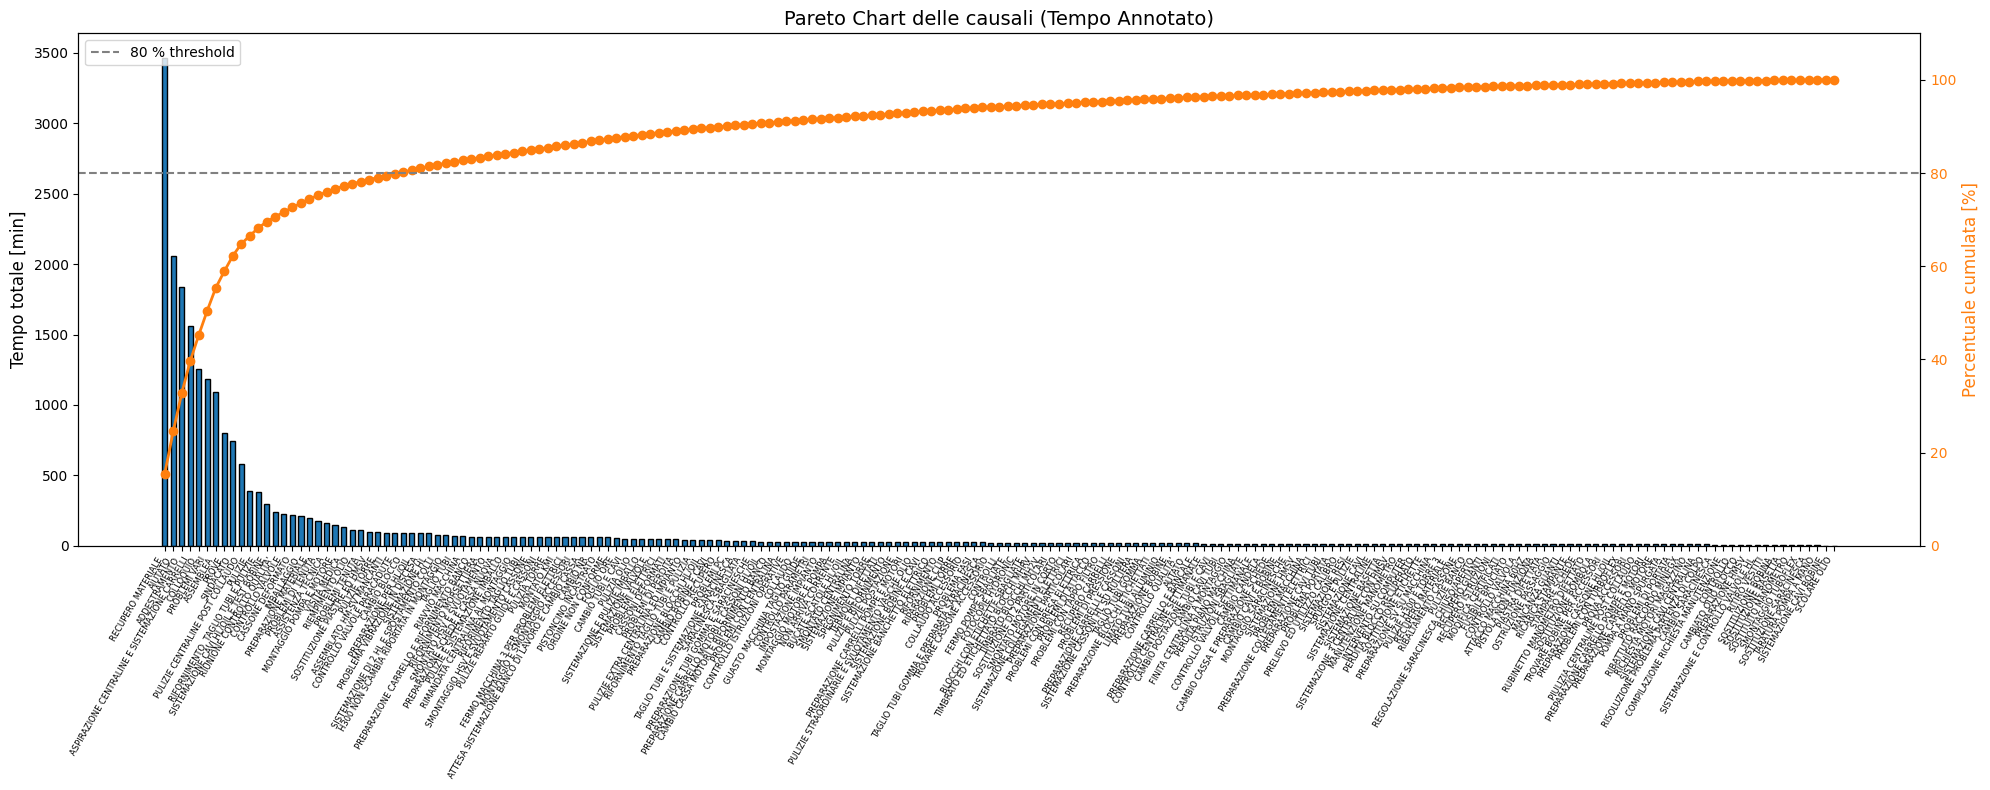

In [179]:
# --- PARETO CHART delle causali ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Copia df e normalizza i nomi colonne
df_p = df.copy()
df_p.columns = (
    df_p.columns
         .str.strip()
         .str.upper()
         .str.replace(r'[\s\[\]]+', '_', regex=True)
         .str.strip('_')
)

# 2) Forza TEMPO_ANNOTATO_MIN a numerico
df_p['TEMPO_ANNOTATO_MIN'] = pd.to_numeric(df_p['TEMPO_ANNOTATO_MIN'], errors='coerce').fillna(0)

# 3) Raggruppa e ordina tutte le causali
grp = (df_p
       .groupby('CAUSALE', observed=True)['TEMPO_ANNOTATO_MIN']
       .sum()
       .sort_values(ascending=False))

# 4) Calcola cumulata percentuale
cum = (grp / grp.sum() * 100).cumsum()

# 5) Prepara le posizioni
x = np.arange(len(grp))
width = 0.6

# 6) Disegna
fig, ax1 = plt.subplots(figsize=(20,8))  # figura più larga ed alta

# barre
ax1.bar(x, grp.values, width=width, edgecolor='black')
ax1.set_ylabel('Tempo totale [min]', fontsize=12)
ax1.set_title('Pareto Chart delle causali (Tempo Annotato)', fontsize=14)

# etichette allineate sui tick
ax1.set_xticks(x)
ax1.set_xticklabels(grp.index, rotation=60, ha='right', fontsize=6)  # font ancora più piccolo

# asse secondario per cumulata
ax2 = ax1.twinx()
ax2.plot(x, cum.values, color='C1', marker='o', linewidth=2)
ax2.axhline(80, color='gray', linestyle='--', label='80 % threshold')
ax2.set_ylabel('Percentuale cumulata [%]', color='C1', fontsize=12)
ax2.tick_params(axis='y', labelcolor='C1', labelsize=10)
ax2.set_ylim(0, 110)
ax2.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# VEDIAMO SE CI SONO POCHE CAUSE CHE GENERANO LA MAGGIOR PARTE DEL TEMPO DI FERMO

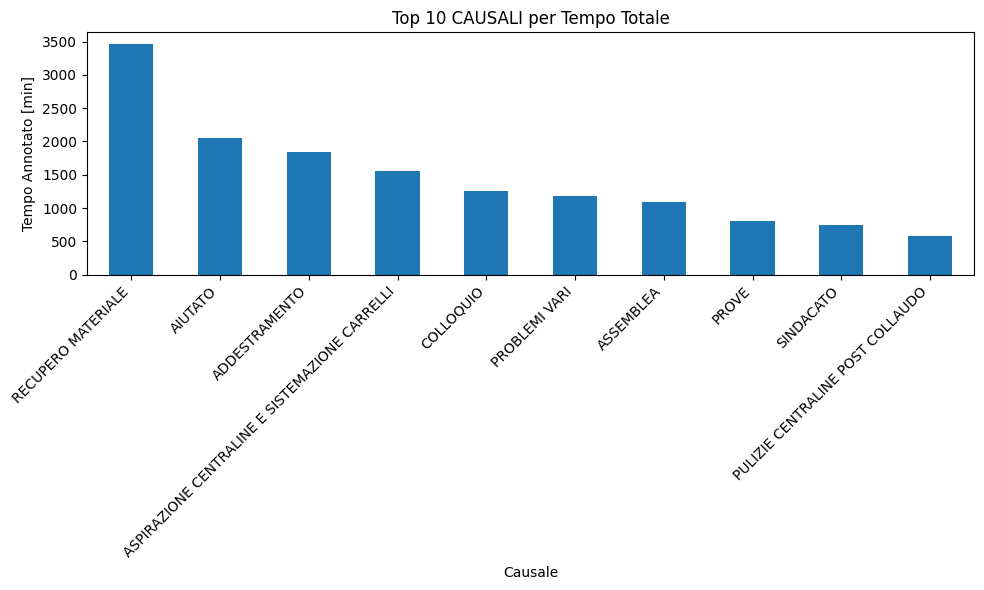

In [180]:
# 2) Calcolo tempo totale per ciascuna causa e selezione top 10
cause_summary = (
    df
    .groupby('CAUSALE')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_values(ascending=False)
)
top10 = cause_summary.head(10)

# 3) Grafico a barre
plt.figure(figsize=(10, 6))
top10.plot(kind='bar')
plt.title('Top 10 CAUSALI per Tempo Totale')
plt.xlabel('Causale')
plt.ylabel('Tempo Annotato [min]')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [181]:
# Suggerisce che agendo su queste poche voci si possono ottenere i maggiori benefici di riduzione del downtime.

# Varianza dei tempi segnati per causale

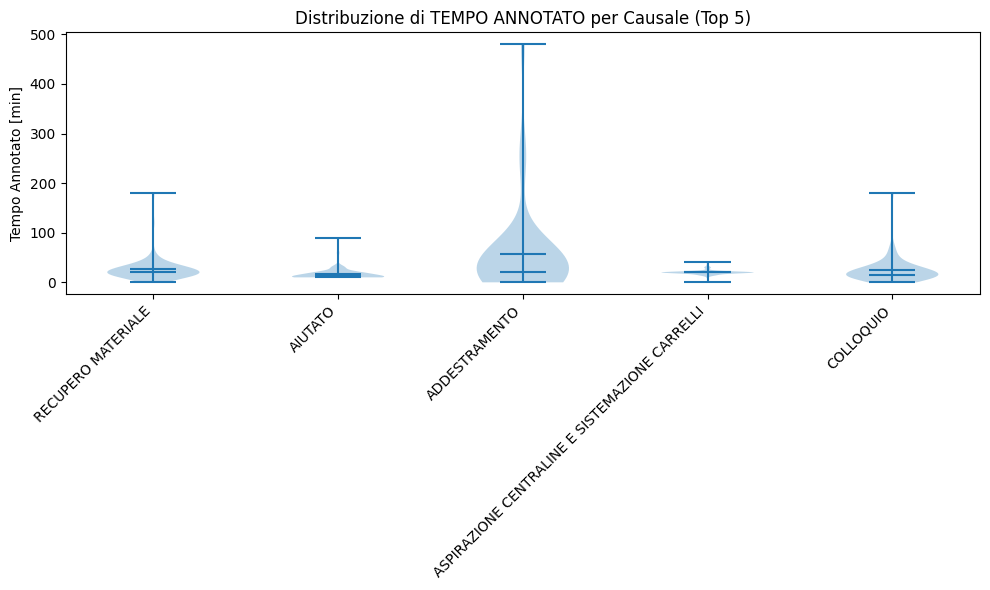

In [182]:
# 2) Seleziona le top 5 causali per tempo totale
cause_tot = df.groupby('CAUSALE')['TEMPO ANNOTATO [min]'].sum()
top5 = cause_tot.nlargest(5).index.tolist()

# 3) Prepara i dati per il violin plot
data = [df[df['CAUSALE'] == c]['TEMPO ANNOTATO [min]'] for c in top5]

# 4) Disegna il violin plot
plt.figure(figsize=(10, 6))
plt.violinplot(data, showmeans=True, showmedians=True)
plt.xticks(range(1, len(top5) + 1), top5, rotation=45, ha='right')
plt.title('Distribuzione di TEMPO ANNOTATO per Causale (Top 5)')
plt.ylabel('Tempo Annotato [min]')
plt.tight_layout()
plt.show()

# L’andamento giornaliero

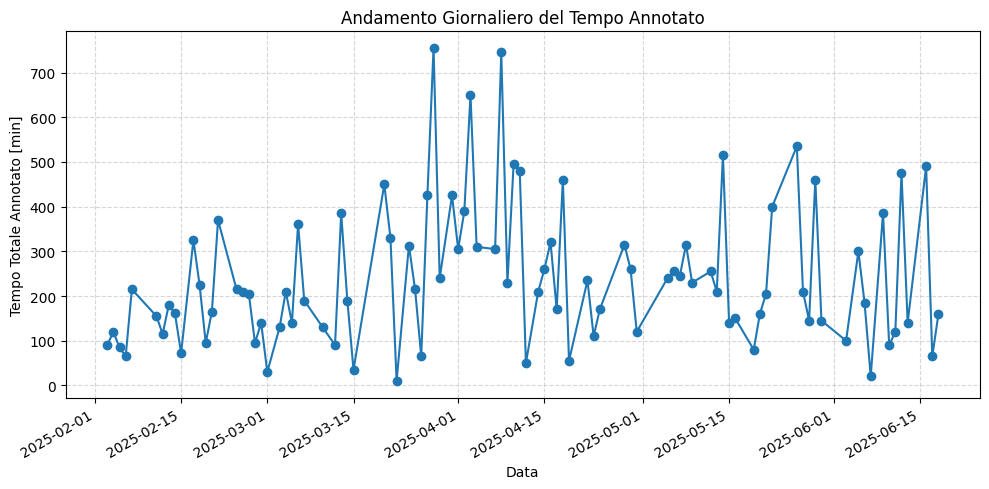

In [183]:
# 2) Convertiamo 'GIORNO' in datetime (formato gg/mm/aaaa o simile)
df['GIORNO'] = pd.to_datetime(df['GIORNO'], dayfirst=True)

# 3) Sommiamo il tempo annotato per ciascun giorno
daily_totals = (
    df
    .groupby('GIORNO')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_index()
)

# 4) Plottiamo
plt.figure(figsize=(10, 5))
daily_totals.plot(kind='line', marker='o')
plt.title('Andamento Giornaliero del Tempo Annotato')
plt.xlabel('Data')
plt.ylabel('Tempo Totale Annotato [min]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [184]:
# C'è elevata variabilità giornaliera

# Probabilmente i giorni a 0 coincidono con fine settimana, festività o giornate con produzione ridotta.

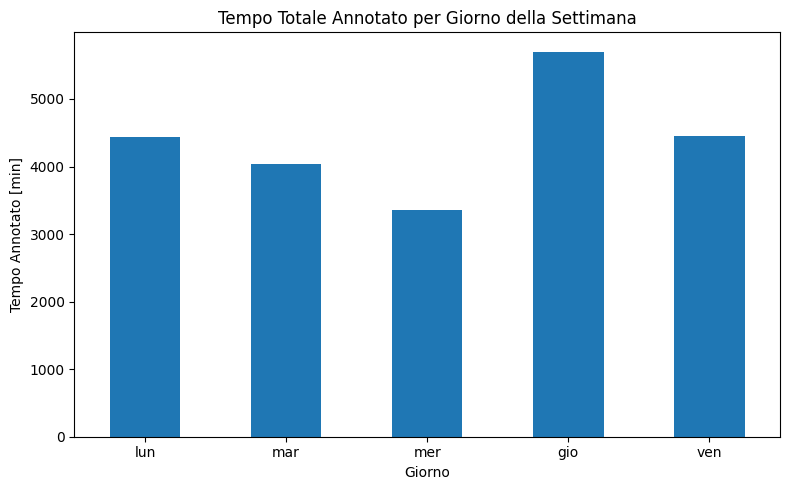

In [185]:
# Andamento delle causali per giorno della settimana

# 2) Somma per giorno della settimana (GG)
#    Assicuriamoci di ordinarli lun-mar-mer-gio-ven
order = ['lun', 'mar', 'mer', 'gio', 'ven']
time_by_weekday = (
    df
    .groupby('GG')['TEMPO ANNOTATO [min]']
    .sum()
    .reindex(order)
)

# 3) Grafico a barre verticali
plt.figure(figsize=(8, 5))
time_by_weekday.plot(kind='bar')
plt.title('Tempo Totale Annotato per Giorno della Settimana')
plt.xlabel('Giorno')
plt.ylabel('Tempo Annotato [min]')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [186]:
# Giovedì, Lunedì e Venerdì sono i giorni più “costosi” in termini di downtime.

# Maggiore stress sulle macchine e/o maggiore volume di produzione verso fine settimana?

<Figure size 1200x600 with 0 Axes>

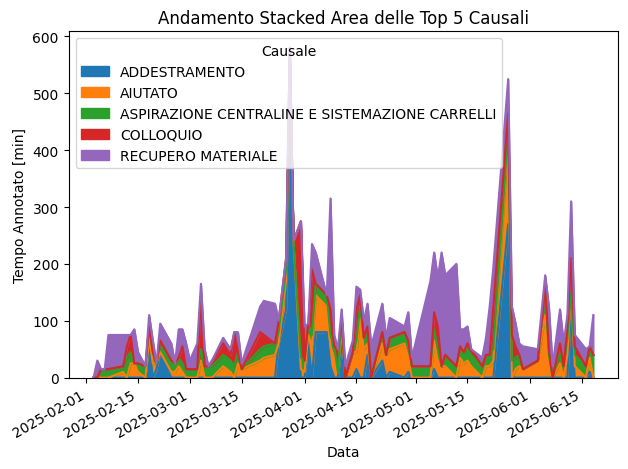

In [187]:
df['GIORNO'] = pd.to_datetime(df['GIORNO'], dayfirst=True)

# 2) Trova le top 5 causali per volume totale
cause_tot = df.groupby('CAUSALE')['TEMPO ANNOTATO [min]'].sum()
top5 = cause_tot.nlargest(5).index.tolist()

# 3) Pivot giornaliero per causale (teniamo solo le top5)
daily = (
    df[df['CAUSALE'].isin(top5)]
    .pivot_table(
        index='GIORNO',
        columns='CAUSALE',
        values='TEMPO ANNOTATO [min]',
        aggfunc='sum',
        fill_value=0
    )
    .sort_index()
)

# 4) Stacked area plot
plt.figure(figsize=(12, 6))
daily.plot.area()
plt.title('Andamento Stacked Area delle Top 5 Causali')
plt.xlabel('Data')
plt.ylabel('Tempo Annotato [min]')
plt.legend(title='Causale', loc='upper left')
plt.tight_layout()
plt.show()

# Operatori che segnano più causali

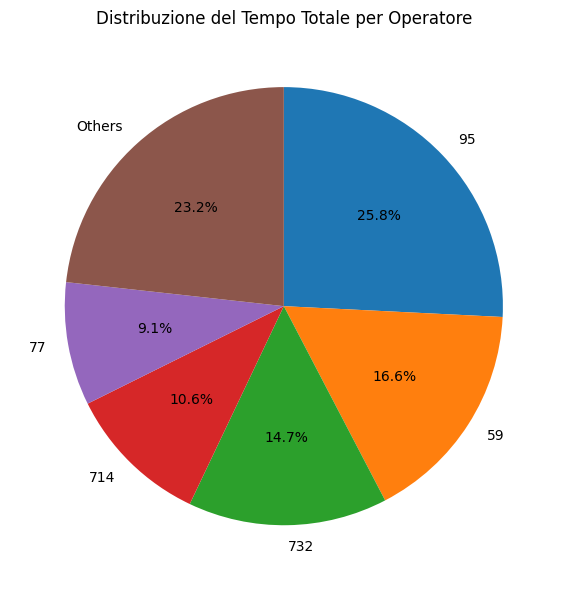

In [188]:
# 2) Calcolo tempo totale per ciascun operatore
op_summary = (
    df
    .groupby('OPERATORE')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_values(ascending=False)
)

# 3) Prendo i primi 5 operatori e raggruppo gli altri in “Others”
top5 = op_summary.head(5).copy()
others = op_summary.iloc[5:].sum()
top5['Others'] = others

# 4) Pie chart
plt.figure(figsize=(6,6))
top5.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title('Distribuzione del Tempo Totale per Operatore')
plt.ylabel('')         # togliamo la label y
plt.tight_layout()
plt.show()

In [189]:
# I primi 5 operatori (95, 714, 59, 77, 719) coprono insieme circa l’81,5 % del tempo di fermo, mentre tutti gli altri stanno sotto il 20 %. 

# In particolare l’operatore 95 da solo genera più di un quarto dell’intero downtime.

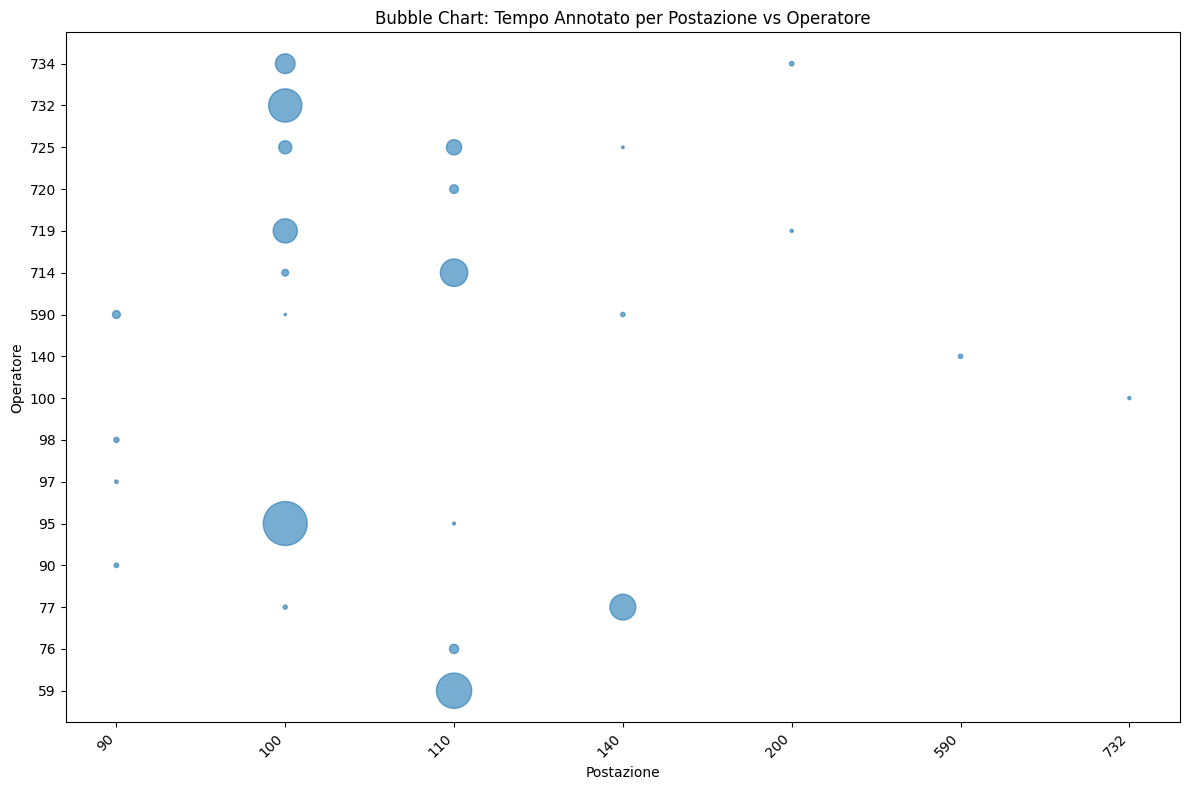

In [190]:
# 2) Aggrega per Postazione e Operatore
agg = (
    df
    .groupby(['POSTAZIONE', 'OPERATORE'])['TEMPO ANNOTATO [min]']
    .sum()
    .reset_index()
)

# 3) Mappa categorie a indici numerici
agg['post_idx'] = agg['POSTAZIONE'].astype('category').cat.codes
agg['op_idx'] = agg['OPERATORE'].astype('category').cat.codes

# 4) Scala dimensioni bolle
max_time = agg['TEMPO ANNOTATO [min]'].max()
agg['size'] = agg['TEMPO ANNOTATO [min]'] / max_time * 1000

# 5) Disegna il bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(agg['post_idx'], agg['op_idx'], s=agg['size'], alpha=0.6)
plt.xticks(
    ticks=range(len(agg['POSTAZIONE'].unique())),
    labels=agg['POSTAZIONE'].astype('category').cat.categories,
    rotation=45, ha='right'
)
plt.yticks(
    ticks=range(len(agg['OPERATORE'].unique())),
    labels=agg['OPERATORE'].astype('category').cat.categories
)
plt.xlabel('Postazione')
plt.ylabel('Operatore')
plt.title('Bubble Chart: Tempo Annotato per Postazione vs Operatore')
plt.tight_layout()
plt.show()

In [191]:
# Andrebbe effettuata normalizzazione per ore lavorate (o per pezzi prodotti): capire se il “record” di operatore 95 è solo perché ha lavorato più ore o perché davvero soffre di più interruzioni.

CAUSALI A MANO columns: ['Unnamed: 0', 'GG', 'SETT', 'GIORNO', 'POSTAZIONE', 'OPERATORE', 'CAUSALE', 'TEMPO ANNOTATO [min]', 'DIFF', '(FORSE) COMPRESO IN', 'CAUSALI POSTAZIONE']
Merge C columns     : ['giornodata', 'gglavorativo', 'giornoset', 'CHIAVE C', 'mese', 'settimana', 'Tabella11.OPERATORE', 'Tabella11.ORARIO STD', 'ORARIO STD', 'ORE LAVORATE', 'STRAORDINARIO']
Map columns         : ['CODICE', 'OPERATORE']

Operatori comuni (12): ['ALESSIO MAZZOLA', 'CAFOLLA STEFANO', 'FABRIS M.GRAZIA', 'FRANCESCONI MIRKO', 'MONTONATI LUCA', 'MUSKAJ FLORJAN', 'PAPPADÀ LUIGI', 'SIMONETTA LUCA', 'SIRACUSA FRANCESCO', 'VALERIA COLLI', 'VIGLIAROLO DONATELLA', 'ZENNARO SAURO']

Downtime normalizzato per operatore:
                OPERATORE  DOWNTIME_MIN  HOURS_WORKED  MIN_PER_HOUR
5         MUSKAJ FLORJAN        1766.0           0.0           inf
11         ZENNARO SAURO        5800.0        1047.0      5.539637
8     SIRACUSA FRANCESCO        3725.0         781.0      4.769526
9          VALERIA COL

C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


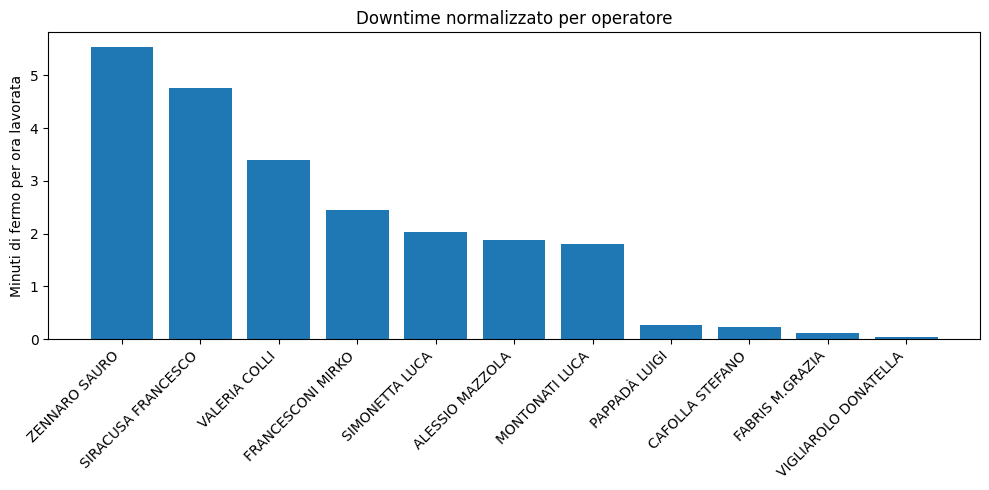

In [192]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Carica i tre fogli
file_path = 'ANALISI CAUSALI OEE.xlsx'
df_cau = pd.read_excel(file_path, sheet_name='CAUSALI A MANO', header=1).iloc[2:].reset_index(drop=True)
df_hr  = pd.read_excel(file_path, sheet_name='Merge C', header=0)
df_map = pd.read_excel(file_path, sheet_name='Mappatura Operatori', header=0)

# 2) Controlla i nomi di colonna
print("CAUSALI A MANO columns:", df_cau.columns.tolist())
print("Merge C columns     :", df_hr.columns.tolist())
print("Map columns         :", df_map.columns.tolist())

# 3) Rinomina le colonne utili
df_cau = df_cau.rename(columns={
    'OPERATORE':             'CODICE',
    'TEMPO ANNOTATO [min]':  'DOWNTIME_MIN'
})
df_hr  = df_hr.rename(columns={
    'Tabella11.OPERATORE':   'OPERATORE',
    'ORE LAVORATE':          'HOURS_WORKED'
})
df_map = df_map.rename(columns={
    'CODICE':   'CODICE',
    'OPERATORE':'OPERATORE'
})

# 4) Pulisci e uniforma i tipi
df_cau['CODICE']       = pd.to_numeric(df_cau['CODICE'], errors='coerce')
df_cau['DOWNTIME_MIN'] = pd.to_numeric(df_cau['DOWNTIME_MIN'], errors='coerce')
df_hr ['HOURS_WORKED'] = pd.to_numeric(df_hr ['HOURS_WORKED'], errors='coerce')

df_map['CODICE']    = pd.to_numeric(df_map['CODICE'], errors='coerce')
df_map['OPERATORE'] = df_map['OPERATORE'].astype(str).str.strip().str.upper()

# 5) Mappa codice → nome operatore
df_cau = df_cau.merge(df_map, on='CODICE', how='left')

# 6) Uniforma i nomi in entrambi i DF
df_cau['OPERATORE'] = df_cau['OPERATORE'].str.strip().str.upper()
df_hr ['OPERATORE'] = df_hr ['OPERATORE'].astype(str).str.strip().str.upper()

# 7) Aggrega downtime e ore lavorate
downtime = df_cau.groupby('OPERATORE')['DOWNTIME_MIN'].sum().reset_index()
hours    = df_hr .groupby('OPERATORE')['HOURS_WORKED'].sum().reset_index()

# 8) Verifica operatori comuni
common = sorted(set(downtime['OPERATORE']).intersection(hours['OPERATORE']))
print(f"\nOperatori comuni ({len(common)}):", common)

# 9) Filtra e unisci solo gli operatori comuni
df_norm = pd.merge(
    downtime[downtime['OPERATORE'].isin(common)],
    hours[ hours['OPERATORE'].isin(common)],
    on='OPERATORE',
    how='inner'
)

# 10) Calcola fermo normalizzato
df_norm['MIN_PER_HOUR'] = df_norm['DOWNTIME_MIN'] / df_norm['HOURS_WORKED']

# 11) Ordina e stampa
df_norm = df_norm.sort_values('MIN_PER_HOUR', ascending=False)
print("\nDowntime normalizzato per operatore:\n", df_norm)

# 12) Grafico a barre
plt.figure(figsize=(10,5))
plt.bar(df_norm['OPERATORE'], df_norm['MIN_PER_HOUR'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Minuti di fermo per ora lavorata')
plt.title('Downtime normalizzato per operatore')
plt.tight_layout()
plt.show()


In [193]:
# Zennaro Sauro e Siracusa Francesco registrano oltre 4 minuti di fermo ogni 1 ora lavorata: sono gli operatori più “colpiti” da downtime, a prescindere dalle ore complessive.
# I “top performer” in termini di efficienza sono Vigliarolo Donatella, Fabris M. Grazia e Cafolla Stefano, con meno di 0.3 min/h.

# Control chart sul series “minuti di fermo per ora” per individuare cambi di tendenza process shiftin modo da monitorare la stabilità del processo nel tempo

Cerco il file in: C:\Users\gatti\Desktop\Moris – esiste? True


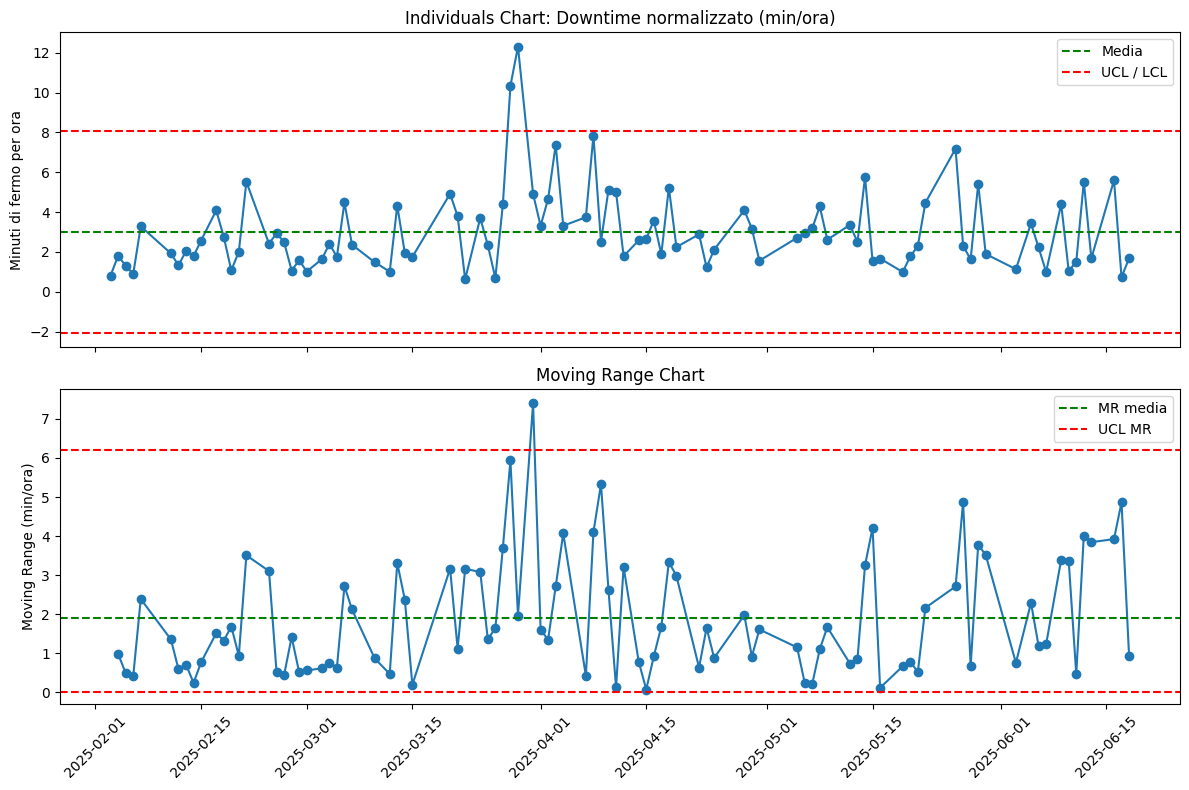

In [194]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ======================
# Control Chart (I-MR)
# ======================

# 1) Imposta il nome file (relativo alla cartella del notebook)
file_name = 'ANALISI CAUSALI OEE.xlsx'
print("Cerco il file in:", os.getcwd(), "– esiste?", os.path.exists(file_name))

# 2) Carica i due fogli
df_cau = pd.read_excel(file_name, sheet_name='CAUSALI A MANO', header=1).iloc[2:].reset_index(drop=True)
df_hr  = pd.read_excel(file_name, sheet_name='Merge C',       header=0)

# 3) Rinomina colonne per chiarezza
df_cau = df_cau.rename(columns={'TEMPO ANNOTATO [min]': 'DOWNTIME_MIN'})
df_hr  = df_hr .rename(columns={'ORE LAVORATE':       'HOURS_WORKED',
                                 'giornodata':          'DATE'})

# 4) Converti tipi
df_cau['GIORNO']       = pd.to_datetime(df_cau['GIORNO'],    dayfirst=True, errors='coerce')
df_cau['DOWNTIME_MIN'] = pd.to_numeric(df_cau['DOWNTIME_MIN'], errors='coerce')
df_hr ['DATE']         = pd.to_datetime(df_hr['DATE'],        dayfirst=True, errors='coerce')
df_hr ['HOURS_WORKED'] = pd.to_numeric(df_hr['HOURS_WORKED'], errors='coerce')

# 5) Aggrega per giorno
daily_downtime = (
    df_cau
    .groupby('GIORNO')['DOWNTIME_MIN']
    .sum()
    .rename('downtime')
    .reset_index()
)
daily_hours = (
    df_hr
    .groupby('DATE')['HOURS_WORKED']
    .sum()
    .rename('hours')
    .reset_index()
)

# 6) Unisci e calcola downtime per ora
daily = pd.merge(daily_downtime, daily_hours,
                 left_on='GIORNO', right_on='DATE', how='inner')
daily['downtime_per_hour'] = daily['downtime'] / daily['hours']

# 7) Calcola media e Moving Range
x      = daily['downtime_per_hour']
mr     = x.diff().abs().dropna()
xbar   = x.mean()
mr_bar = mr.mean()

# Costanti per I-MR chart (n=2 per MR)
d2 = 1.128  
D4 = 3.267  
D3 = 0

# Limiti Individuals chart
sigma_est = mr_bar / d2
ucl_x     = xbar + 3 * sigma_est
lcl_x     = xbar - 3 * sigma_est

# Limiti MR chart
ucl_mr = D4 * mr_bar
lcl_mr = D3 * mr_bar

# 8) Plot I-MR chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Individuals Chart
ax1.plot(daily['GIORNO'], x, marker='o', linestyle='-')
ax1.axhline(xbar, color='green', linestyle='--', label='Media')
ax1.axhline(ucl_x, color='red', linestyle='--',   label='UCL / LCL')
ax1.axhline(lcl_x, color='red', linestyle='--')
ax1.set_title('Individuals Chart: Downtime normalizzato (min/ora)')
ax1.set_ylabel('Minuti di fermo per ora')
ax1.legend(loc='upper right')

# Moving Range Chart
ax2.plot(daily['GIORNO'][1:], mr, marker='o', linestyle='-')
ax2.axhline(mr_bar, color='green', linestyle='--', label='MR media')
ax2.axhline(ucl_mr, color='red', linestyle='--',   label='UCL MR')
ax2.axhline(lcl_mr, color='red', linestyle='--')
ax2.set_title('Moving Range Chart')
ax2.set_ylabel('Moving Range (min/ora)')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [195]:
# In alto, l’Individuals Chart mostra il downtime normalizzato (min/ora). La linea verde è la media (circa 3 min/ora), le linee rosse sono i limiti di controllo a ±3 sigma.

# Ci sono giorni chiaramente out‐of‐control, con fermo per ora sopra gli 8 minuti (oltre UCL) o sotto −2 minuti (impossibile ma dovuto a variazioni e piccole ore lavorate).

# In basso, il Moving Range Chart evidenzia i salti tra giorni consecutivi. I picchi più alti corrispondono ai cambi bruschi di downtime normalizzato (ad esempio dopo un fine‐settimana o un cambio turno).

# Prossimi passi

# Identifica le date out‐of‐control e analizza le causali di quei giorni nel detail di df_cau.

# Monitora questo chart con nuovi dati: appena un nuovo giorno supera UCL, segnala un’anomalia.

# Se emerge un pattern (es. dopo certi giorni della settimana), potresti fare una run chart stratificata per weekday.

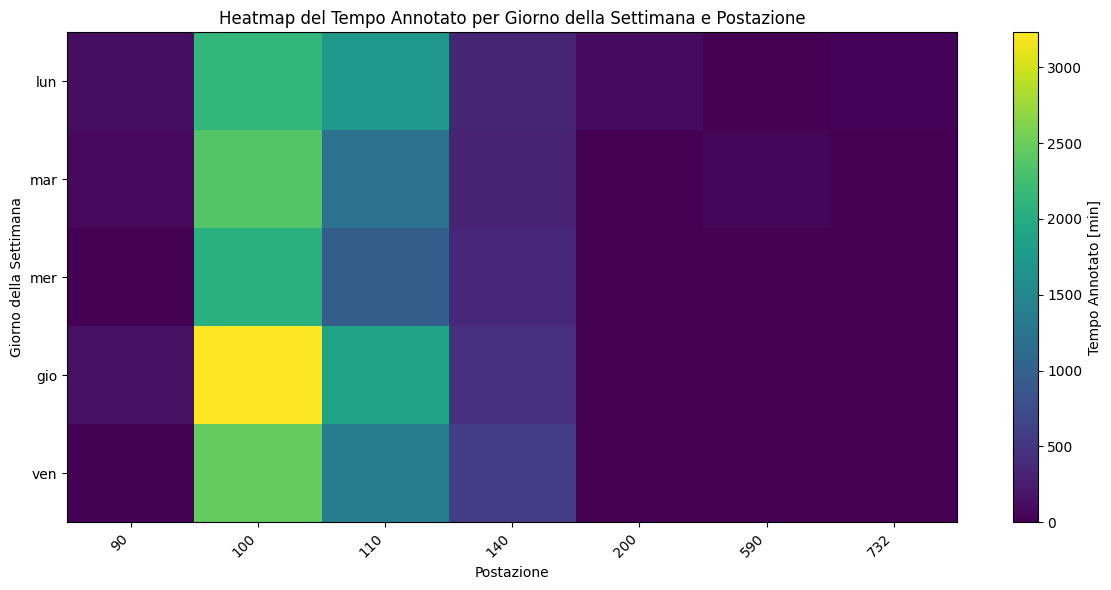

In [196]:
# 2) Prepara la heatmap: somma per Giorno della Settimana (GG) e Postazione
df['GG'] = df['GG'].str.strip()
order = ['lun', 'mar', 'mer', 'gio', 'ven']
heatmap_data = (
    df
    .groupby(['GG', 'POSTAZIONE'])['TEMPO ANNOTATO [min]']
    .sum()
    .unstack(fill_value=0)
    .reindex(index=order)
)

# 3) Disegna la heatmap
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(heatmap_data.values, aspect='auto')

# Etichette assi
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
ax.set_yticks(range(len(order)))
ax.set_yticklabels(order)

# Titoli
ax.set_xlabel('Postazione')
ax.set_ylabel('Giorno della Settimana')
ax.set_title('Heatmap del Tempo Annotato per Giorno della Settimana e Postazione')

# Colorbar
cbar = fig.colorbar(im, ax=ax, label='Tempo Annotato [min]')

plt.tight_layout()
plt.show()

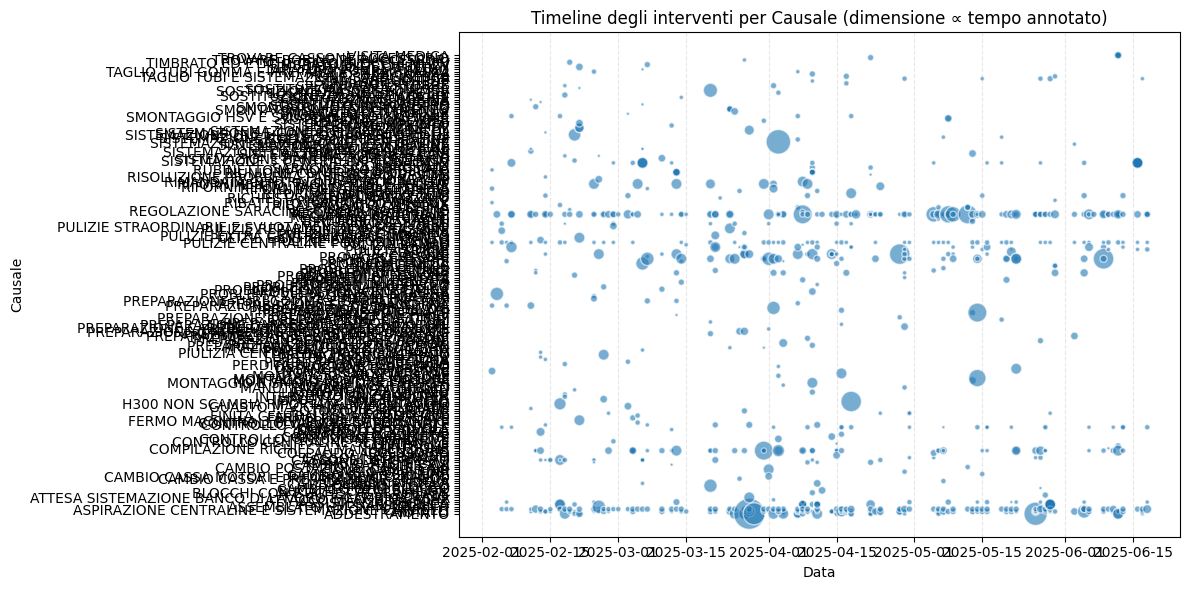

In [197]:
# 2) Mappa le causali su un asse numerico
df['cause_idx'] = df['CAUSALE'].astype('category').cat.codes
cause_labels = df['CAUSALE'].astype('category').cat.categories

# 3) Scala la dimensione delle bolle
max_t = df['TEMPO ANNOTATO [min]'].max()
df['bubble_size'] = df['TEMPO ANNOTATO [min]'] / max_t * 500  # scala fino a ~500 punti

# 4) Scatter timeline
plt.figure(figsize=(12, 6))
plt.scatter(
    df['GIORNO'], 
    df['cause_idx'], 
    s=df['bubble_size'], 
    alpha=0.6, 
    edgecolors='w'
)
plt.yticks(ticks=range(len(cause_labels)), labels=cause_labels)
plt.xlabel('Data')
plt.ylabel('Causale')
plt.title('Timeline degli interventi per Causale (dimensione ∝ tempo annotato)')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

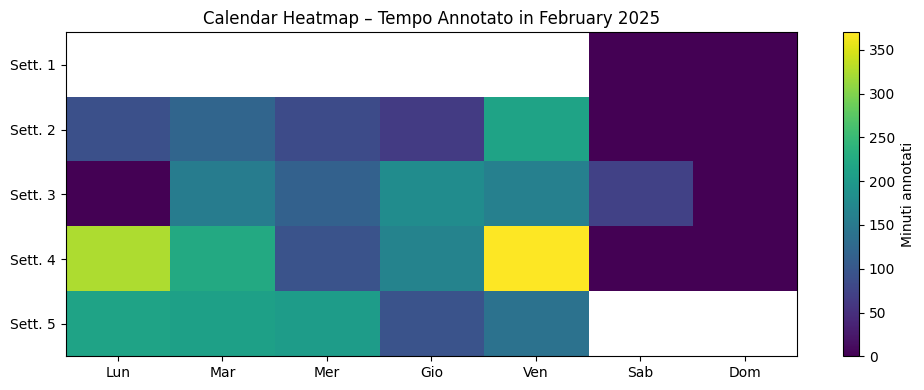

In [162]:
import calendar


# 2) Totali giornalieri
daily_totals = df.groupby('GIORNO')['TEMPO ANNOTATO [min]'].sum()

# 3) Costruisci la “calendar matrix” per il mese
year = daily_totals.index.year.unique()[0]
month = daily_totals.index.month.unique()[0]
cal = calendar.monthcalendar(year, month)

# 4) Popola la matrice con i valori, NaN per i giorni fuori mese
mat = np.full((len(cal), 7), np.nan)
for week_i, week in enumerate(cal):
    for day_i, day in enumerate(week):
        if day != 0:
            date = pd.Timestamp(year, month, day)
            mat[week_i, day_i] = daily_totals.get(date, 0)

# 5) Visualizzazione heatmap “calendario”
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(mat, aspect='auto')

# etichette asse X (giorni)
ax.set_xticks(range(7))
ax.set_xticklabels(['Lun','Mar','Mer','Gio','Ven','Sab','Dom'])
# etichette asse Y (settimane)
ax.set_yticks(range(len(cal)))
ax.set_yticklabels([f'Sett. {i+1}' for i in range(len(cal))])

ax.set_title(f'Calendar Heatmap – Tempo Annotato in {calendar.month_name[month]} {year}')
cbar = plt.colorbar(im, ax=ax, label='Minuti annotati')

plt.tight_layout()
plt.show()

In [163]:
# Inserisci questa cella e rilancia
print(df.columns.tolist())


['Unnamed: 0', 'GG', 'SETT', 'GIORNO', 'POSTAZIONE', 'OPERATORE', 'CAUSALE', 'TEMPO ANNOTATO [min]', 'DIFF', '(FORSE) COMPRESO IN', 'CAUSALI POSTAZIONE', 'cause_idx', 'bubble_size']


C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                 
Dep. Variable:     TEMPO ANNOTATO [min]   No. Observations:                  136
Model:                   ARIMA(2, 1, 2)   Log Likelihood                -878.759
Date:                  Fri, 18 Jul 2025   AIC                           1767.518
Time:                          12:07:44   BIC                           1782.045
Sample:                      02-03-2025   HQIC                          1773.421
                           - 06-18-2025                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7863      0.150      5.227      0.000       0.491       1.081
ar.L2         -0.4007      0.084     -4.770      0.000      -0.565      -0.236
ma.L1         -1.5278      0.153    

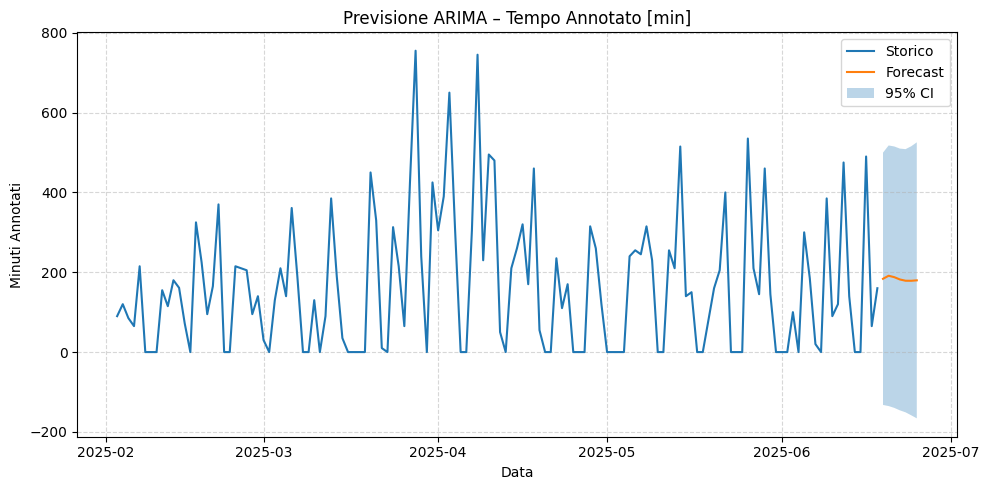

In [164]:
# 18) Previsione del tempo annotato con ARIMA
# — Installa statsmodels se non l’hai già fatto
import micropip
await micropip.install(["statsmodels"])

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1) Ricava la serie storica giornaliera
daily_totals = df.groupby('GIORNO')['TEMPO ANNOTATO [min]'].sum().asfreq('D').fillna(0)

# 2) Definisci l’ordine (p,d,q) del modello – qui un esempio (2,1,2)
order = (2, 1, 2)
model = sm.tsa.ARIMA(daily_totals, order=order)

# 3) Stima il modello
res = model.fit()
print(res.summary())

# 4) Previsioni per i prossimi 7 giorni
n_steps = 7
forecast_res = res.get_forecast(steps=n_steps)
forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# 5) Plot: storico + forecast + intervallo di confidenza
plt.figure(figsize=(10,5))
plt.plot(daily_totals.index, daily_totals, label='Storico')
plt.plot(forecast.index,    forecast,     label='Forecast')
plt.fill_between(forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 alpha=0.3,
                 label='95% CI')
plt.title('Previsione ARIMA – Tempo Annotato [min]')
plt.xlabel('Data')
plt.ylabel('Minuti Annotati')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


R² sul test set: -0.203
Top 10 feature più importanti:
dow__DAY_OF_WEEK                                             0.315697
causa_ohe__CAUSALE_SISTEMAZIONE CAVI HL/OIL E TEST BOBINE    0.132069
causa_ohe__CAUSALE_ADDESTRAMENTO                             0.109610
causa_ohe__CAUSALE_IMBALLAGGIO                               0.083398
causa_ohe__CAUSALE_PREPARAZIONE MATERIALE                    0.041219
causa_ohe__CAUSALE_MONTAGGIO POMPA E MOTORE                  0.039240
causa_ohe__CAUSALE_PROBLEMI VARI                             0.027271
causa_ohe__CAUSALE_PROVE                                     0.018243
causa_ohe__CAUSALE_ASSEMBLEA                                 0.016611
causa_ohe__CAUSALE_RIFORNIMENTO, TAGLIO TUBI E PULIZIE       0.015766
dtype: float64


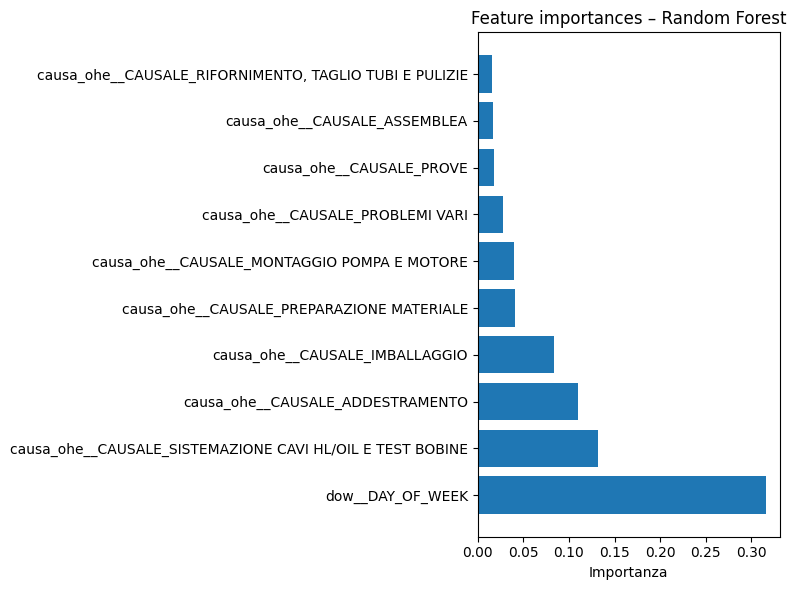

In [165]:
# Previsione del tempo annotato con Random Forest – copia e incolla solo questa cella

# 1) Installa scikit-learn se non l'hai già fatto
import micropip
await micropip.install(["scikit-learn"])

# 2) Import delle librerie
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 3) Copia del DataFrame originale
df_ml = df.copy()

# 4) Normalizzazione nomi colonne
df_ml.columns = (
    df_ml.columns
         .str.strip()
         .str.upper()
         .str.replace(r"\s+", "_", regex=True)
)

# 5) (Opzionale) Rinomina 'CAUSALE' in 'CAUSALE_DI_FERMO'
# df_ml.rename(columns={'CAUSALE': 'CAUSALE_DI_FERMO'}, inplace=True)

# 6) Feature engineering sul giorno della settimana
df_ml['GIORNO'] = pd.to_datetime(df_ml['GIORNO'])
df_ml['DAY_OF_WEEK'] = df_ml['GIORNO'].dt.dayofweek

# 7) Definizione di feature e target
# Se hai rinominato la colonna, sostituisci 'CAUSALE' con 'CAUSALE_DI_FERMO'
X = df_ml[['DAY_OF_WEEK', 'CAUSALE']]
y = df_ml['TEMPO_ANNOTATO_[MIN]']

# 8) Pipeline con One-Hot Encoding su 'CAUSALE'
preprocessor = ColumnTransformer([
    ('causa_ohe', OneHotEncoder(handle_unknown='ignore'), ['CAUSALE']),
    ('dow', 'passthrough', ['DAY_OF_WEEK'])
])

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 9) Suddivisione train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 10) Addestramento del modello
pipeline.fit(X_train, y_train)

# 11) Valutazione sul test set
r2 = pipeline.score(X_test, y_test)
print(f"R² sul test set: {r2:.3f}")

# 12) Calcolo importanza delle feature
rf = pipeline.named_steps['rf']
feat_names = pipeline.named_steps['preproc'].get_feature_names_out()
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

# 13) Stampa top 10 feature più importanti
print("Top 10 feature più importanti:")
print(feat_imp.head(10))

# 14) Grafico delle importanze
plt.figure(figsize=(8,6))
plt.barh(feat_imp.head(10).index, feat_imp.head(10).values)
plt.xlabel('Importanza')
plt.title('Feature importances – Random Forest')
plt.tight_layout()
plt.show()


Explained variance ratio delle 2 PC: [0.04305412 0.03121602]


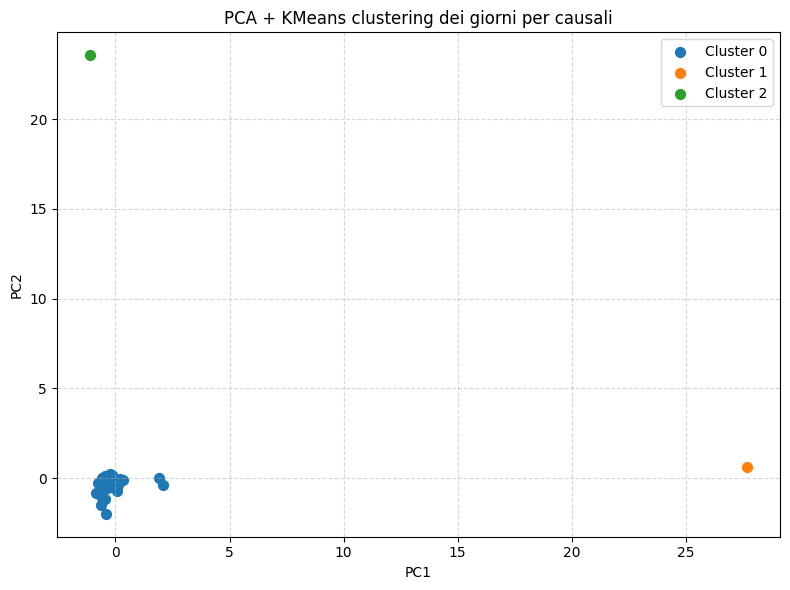

Numero di giorni per cluster:
 0    92
1     1
2     1
Name: count, dtype: int64


In [166]:
# --- Analisi avanzata: PCA + KMeans clustering dei giorni in base alle causali ---

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1) Copia del DataFrame e normalizzazione dei nomi colonne
df_cluster = df.copy()
df_cluster.columns = (
    df_cluster.columns
        .str.strip()
        .str.upper()
        .str.replace(r"\s+", "_", regex=True)
)

# 2) Assicurati che 'GIORNO' sia datetime
df_cluster['GIORNO'] = pd.to_datetime(df_cluster['GIORNO'])

# 3) Aggrega il tempo annotato per ogni giorno × causale
agg = (
    df_cluster
      .groupby(['GIORNO', 'CAUSALE'])['TEMPO_ANNOTATO_[MIN]']
      .sum()
      .reset_index()
)

# 4) Pivot: righe=GIORNO, colonne=CAUSALE, valori=minuti
pivot = agg.pivot(index='GIORNO', columns='CAUSALE', values='TEMPO_ANNOTATO_[MIN]').fillna(0)

# 5) Standardizzazione (mean=0, var=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot)

# 6) PCA → riduci a 2 componenti
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio delle 2 PC:", pca.explained_variance_ratio_)

# 7) K-Means (3 cluster, cambia n_clusters se vuoi)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

# 8) Scatter plot delle 2 PC colorato per cluster
plt.figure(figsize=(8,6))
for cl in sorted(set(labels)):
    mask = labels == cl
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {cl}', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA + KMeans clustering dei giorni per causali')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 9) Dimensione di ciascun cluster
cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("Numero di giorni per cluster:\n", cluster_sizes)


C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 196, but rank is 24
  warnings.warn('covariance of constraints does not have full '


=== ANOVA Table ===
                    sum_sq     df         F        PR(>F)
C(CAUSALE)  753080.440693  196.0  4.645779  4.378528e-12
Residual    560733.397078  678.0       NaN           NaN

=== Tukey HSD ===
                                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                    group1                                         group2                     meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------------------------------------------------------------------------
                                 ADDESTRAMENTO                                        AIUTATO -40.7927    0.0  -61.7562 -19.8291   True
                                 ADDESTRAMENTO ASPIRAZIONE CENTRALINE E SISTEMAZIONE CARRELLI    -37.5    0.0  -59.6769 -15.3231   True
                                 ADDESTRAMENTO                                      ASSEMBLEA    -21.0  0.40

C:\Users\gatti\AppData\Local\Temp\ipykernel_15756\1005965575.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showfliers=False)


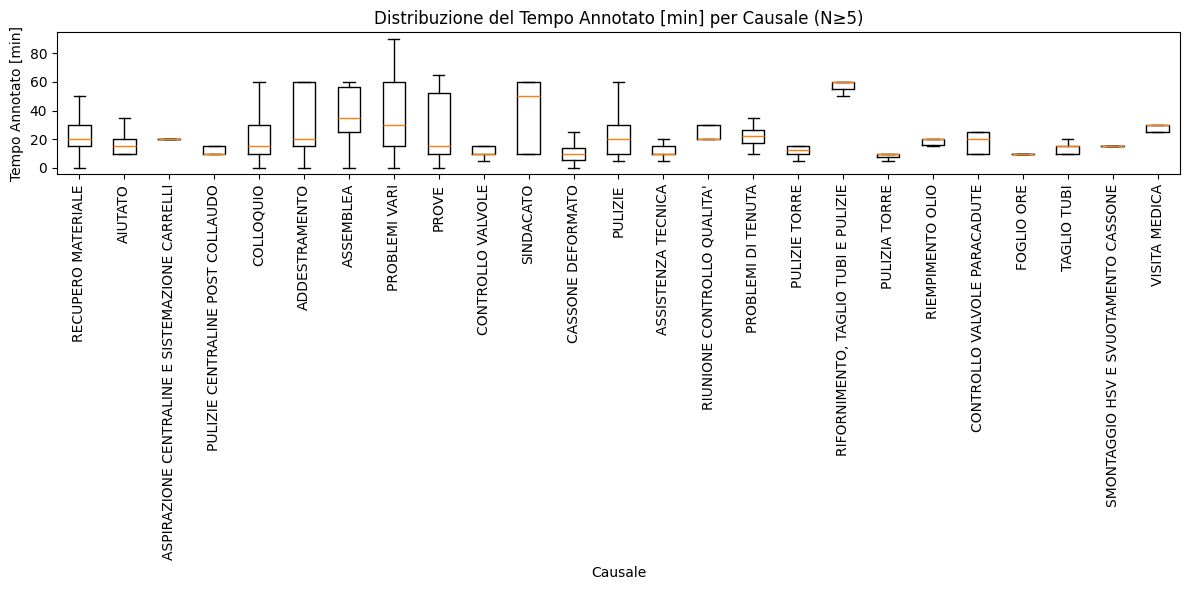

In [167]:
# --- Analisi avanzata: ANOVA + Tukey HSD per differenze tra causali ---

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1) Copia del DataFrame e normalizzazione/rimozione caratteri invalidi
df_an = df.copy()
df_an.columns = (
    df_an.columns
         .str.strip()
         .str.upper()
         .str.replace(r"\s+", "_", regex=True)
         .str.replace(r"[\[\]]", "", regex=True)   # rimuove le parentesi quadre
)

# 2) Converto in categoria e filtro causali con N>=5 osservazioni
df_an['CAUSALE'] = df_an['CAUSALE'].astype('category')
counts = df_an['CAUSALE'].value_counts()
valid = counts[counts >= 5].index
df_an = df_an[df_an['CAUSALE'].isin(valid)]

# 3) Fit modello ANOVA one-way: Tempo ~ Causale
model = ols('TEMPO_ANNOTATO_MIN ~ C(CAUSALE)', data=df_an).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("=== ANOVA Table ===\n", anova_table)

# 4) Post-hoc Tukey HSD per confronti multipli
tukey = pairwise_tukeyhsd(
    endog=df_an['TEMPO_ANNOTATO_MIN'],
    groups=df_an['CAUSALE'],
    alpha=0.05
)
print("\n=== Tukey HSD ===\n", tukey.summary())

# 5) Boxplot delle distribuzioni per causale
plt.figure(figsize=(12,6))
cats = valid.tolist()
data = [df_an[df_an['CAUSALE']==c]['TEMPO_ANNOTATO_MIN'] for c in cats]
plt.boxplot(data, labels=cats, showfliers=False)
plt.xticks(rotation=90)
plt.title('Distribuzione del Tempo Annotato [min] per Causale (N≥5)')
plt.xlabel('Causale')
plt.ylabel('Tempo Annotato [min]')
plt.tight_layout()
plt.show()


In [168]:
# --- Analisi avanzata: Linear Mixed-Effects Model (causali fissi + operatori casuali) ---

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# 1) Copia DataFrame e normalizza colonne come prima
df_mixed = df.copy()
df_mixed.columns = (
    df_mixed.columns
         .str.strip()
         .str.upper()
         .str.replace(r"\s+", "_", regex=True)
         .str.replace(r"[\[\]]", "", regex=True)
)

# 2) Assicurati che GIORNO sia datetime (non strettamente necessario qui)
df_mixed['GIORNO'] = pd.to_datetime(df_mixed['GIORNO'])

# 3) Filtra causali con almeno 5 occorrenze (per stabilità di stima)
counts = df_mixed['CAUSALE'].value_counts()
valid = counts[counts >= 5].index
df_mixed = df_mixed[df_mixed['CAUSALE'].isin(valid)]

# 4) Opzionale: converti OPERATORE in categoria e filtra se poche occorrenze
df_mixed['OPERATORE'] = df_mixed['OPERATORE'].astype('category')
op_counts = df_mixed['OPERATORE'].value_counts()
valid_ops = op_counts[op_counts >= 5].index
df_mixed = df_mixed[df_mixed['OPERATORE'].isin(valid_ops)]

# 5) Definisci e stima il modello misto:
#    - TEMPO_ANNOTATO_MIN ~ 1 + C(CAUSALE) [effetti fissi]
#    - (1 | OPERATORE)        [intercetta casuale per operatore]
md = mixedlm(
    "TEMPO_ANNOTATO_MIN ~ C(CAUSALE)",
    data=df_mixed,
    groups=df_mixed["OPERATORE"]
)
mdf = md.fit(reml=False)
print(mdf.summary())

# 6) Estrai e visualizza la componente di varianza
var_components = mdf.cov_re  # varianza random intercept
resid_var      = mdf.scale   # varianza residua
print("\nVarianza effetti casuali (operatori):\n", var_components)
print(f"Varianza residua: {resid_var:.2f}")

# 7) (Opzionale) Random effects stimati per ogni operatore
re_ops = mdf.random_effects
print("\nRandom intercept per operatore (prime 10):")
for op, re_ in list(re_ops.items())[:10]:
    print(f"  {op}: {re_['Group']:.2f}")


                                  Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               TEMPO_ANNOTATO_MIN
No. Observations:               692                   Method:                           ML                
No. Groups:                     9                     Scale:                            725.9697          
Min. group size:                6                     Log-Likelihood:                   -3268.8594        
Max. group size:                231                   Converged:                        Yes               
Mean group size:                76.9                                                                      
----------------------------------------------------------------------------------------------------------
                                                              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------

=== Two‐way ANOVA (Tipo II) ===
                                sum_sq     df          F        PR(>F)
C(RISORSA)                 3902.296748   11.0  13.316284  4.118138e-06
C(OPERAZIONE)                      NaN    3.0        NaN           NaN
C(RISORSA):C(OPERAZIONE)  15810.246584   33.0  17.983745  5.029152e-26
Residual                   4688.751626  176.0        NaN           NaN


C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 2
  warnings.warn('covariance of constraints does not have full '
C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does not have full '
C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
C:\Users\gatti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\

<Figure size 1000x600 with 0 Axes>

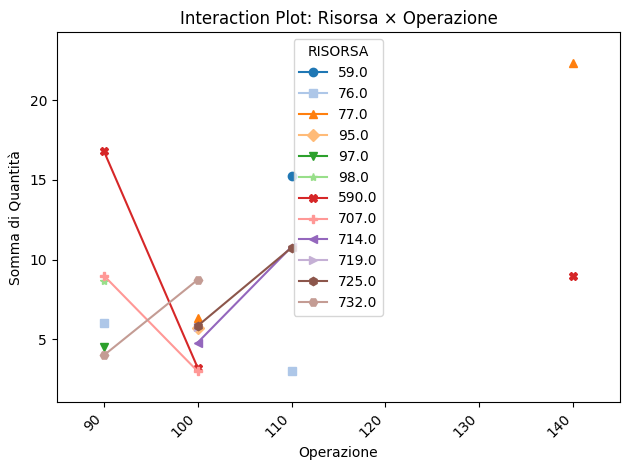

In [169]:
# --- Two‐way ANOVA + interaction plot (markers e colori dinamici) ---

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import unicodedata
import re

# 1) Carica il foglio “Risorsa_Operazione”
file_path = "ANALISI CAUSALI OEE.xlsx"
df_ro = pd.read_excel(file_path, sheet_name="Risorsa_Operazione", header=2)

# 2) Normalizza i nomi delle colonne
def normalize(col):
    s = unicodedata.normalize("NFKD", str(col)).encode("ascii","ignore").decode()
    s = s.strip().upper()
    s = re.sub(r'[^A-Z0-9]+','_',s).strip('_')
    return s

df_ro.columns = [normalize(c) for c in df_ro.columns]

# 3) Trova le colonne chiave e rinominale
cols = df_ro.columns.tolist()
ris_col = next(c for c in cols if "RISORSA" in c)
op_col  = next(c for c in cols if "OPERAZIONE" in c)
qt_col  = next(c for c in cols if "QUANTITA" in c or "QUANTITY" in c)

df_ro = df_ro.rename(columns={
    ris_col: "RISORSA",
    op_col:  "OPERAZIONE",
    qt_col:  "SOMMA_DI_QUANTITA"
})

# 4) Prepara i tipi
df_ro["RISORSA"] = df_ro["RISORSA"].astype("category")
df_ro["OPERAZIONE"] = df_ro["OPERAZIONE"].astype("category")
df_ro["SOMMA_DI_QUANTITA"] = pd.to_numeric(df_ro["SOMMA_DI_QUANTITA"], errors="coerce").fillna(0)

# 5) Two‐way ANOVA con interazione
model = ols("SOMMA_DI_QUANTITA ~ C(RISORSA) * C(OPERAZIONE)", data=df_ro).fit()
anova_table = anova_lm(model, typ=2)
print("=== Two‐way ANOVA (Tipo II) ===")
print(anova_table)

# 6) Interaction plot con markers e colori dinamici
n_traces = df_ro["RISORSA"].nunique()
# palette e markers predefiniti
palette = plt.cm.tab20.colors
markers_list = ["o","s","^","D","v","*","X","P","<",">","h","H","+","x","."]

colors = palette[:n_traces]
markers = markers_list[:n_traces]

plt.figure(figsize=(10,6))
interaction_plot(
    x=df_ro["OPERAZIONE"],
    trace=df_ro["RISORSA"],
    response=df_ro["SOMMA_DI_QUANTITA"],
    colors=colors,
    markers=markers,
    ms=6
)
plt.xlabel("Operazione")
plt.ylabel("Somma di Quantità")
plt.title("Interaction Plot: Risorsa × Operazione")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
